### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import soundfile as sf
import tensorflow as tf
from scipy.io import wavfile
import keras
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 
from keras import regularizers
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio
import seaborn as sns
import os
import random
import csv
import re
import tempfile
import zipfile
from pydub import AudioSegment 


C:\Users\H P\anaconda3\envs\ALX_Creating_environment\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### Create features CSV

In [2]:

def create_features_csv(zip_path, csv_path):
    # Temporary directory to extract the zip contents
    temp_dir = tempfile.mkdtemp()

    # Extract the zip contents
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # Main directory containing subdirectories with .wav files
    main_directory = temp_dir

    # Define the regular expression pattern to extract information from the filename
    pattern = re.compile(r'(?P<gender>ml|fm)\d+_(?P<emotion>ang|hap|sad|neu).+\.wav')
    
    # List to store extracted data
    data_list = []

    def get_audio_duration(file_path):
        audio = AudioSegment.from_file(file_path)
        return audio.duration_seconds

    def extract_features(file_path):
        # Load the audio file
        audio, _ = librosa.load(file_path)

        # Calculate zero-crossing rate
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(audio))

        # Calculate RMSE
        rmse = np.mean(librosa.feature.rms(y=audio))

        # Calculate MFCC
        mfccs = librosa.feature.mfcc(y=audio, n_mfcc=13).tolist()

        # Calculate Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio).tolist()

        # Calculate chroma STFT
        chroma_stft = librosa.feature.chroma_stft(y=audio).tolist()

        return zero_crossing_rate, rmse, mfccs, mel_spectrogram, chroma_stft

    # Loop through subdirectories in the main directory
    for subdir in os.listdir(main_directory):
        subdirectory_path = os.path.join(main_directory, subdir)

        if os.path.isdir(subdirectory_path):
            # Loop through .wav files in each subdirectory
            for filename in os.listdir(subdirectory_path):
                if filename.endswith('.wav'):
                    # Extract information using the regular expression pattern
                    match = pattern.match(filename)

                    if match:
                        # Get the extracted information
                        gender = match.group('gender')
                        raw_emotion = match.group('emotion')

                        # Map raw emotion to labeled emotion
                        if raw_emotion.lower() == 'hap':
                            emotion = 'Happy'
                        elif raw_emotion.lower() == 'ang':
                            emotion = 'Angry'
                        elif raw_emotion.lower() == 'sad':
                            emotion = 'Sad'
                        elif raw_emotion.lower() == 'neu':
                            emotion = 'Neutral'

                        # Get audio duration
                        file_path = os.path.join(subdirectory_path, filename)
                        duration = get_audio_duration(file_path)

                        # Calculate additional features
                        zero_crossing_rate, rmse, mfccs, mel_spectrogram, chroma_stft = extract_features(file_path)

                        # Append data to the list
                        data_list.append({
                            'filename': filename,
                            'gender': 'Female' if 'fm' in filename.lower() else 'Male',
                            'emotion': emotion,
                            'subdirectory': subdir,
                            'duration': duration,
                            'zero_crossing_rate': np.mean(zero_crossing_rate),
                            'rmse': np.mean(rmse),
                            'mfccs': mfccs,
                            'mel_spectrogram': mel_spectrogram,
                            'chroma_stft': chroma_stft
                        })

    # Define the CSV file path
    csv_file_path = csv_path

    # Write data to CSV file
    fieldnames = ['filename', 'gender', 'emotion', 'subdirectory', 'duration',
                  'zero_crossing_rate', 'rmse', 'mfccs', 'mel_spectrogram', 'chroma_stft']

    with open(csv_file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the header
        writer.writeheader()

        # Write the data
        writer.writerows(data_list)

    print(f'CSV file created at {csv_file_path}')
    df = pd.read_csv(csv_file_path)
    return df


In [3]:

def create_features_csv_merged(folder_path, csv_path):
    main_directory = folder_path

    # Define the regular expression pattern to extract information from the filename
    pattern = re.compile(r'(?P<gender>MAL|FEM)_(?P<name>.+?)_(?P<emotion>sad|neu|hap|ang)_\d+_(?P<augmentation>[a-z]+)\.wav')

    # List to store extracted data
    data_list = []

    def get_audio_duration(file_path):
        audio = AudioSegment.from_file(file_path)
        return audio.duration_seconds

    def extract_features(file_path):
        # Load the audio file
        audio, _ = librosa.load(file_path)

        # Calculate zero-crossing rate
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(audio))

        # Calculate RMSE
        rmse = np.mean(librosa.feature.rms(y=audio))

        # Calculate MFCC
        mfccs = librosa.feature.mfcc(y=audio, n_mfcc=13).tolist()

        # Calculate Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio).tolist()

        # Calculate chroma STFT
        chroma_stft = librosa.feature.chroma_stft(y=audio).tolist()

        return zero_crossing_rate, rmse, mfccs, mel_spectrogram, chroma_stft

    # Loop through WAV files in the main directory
    for filename in os.listdir(main_directory):
        if filename.endswith('.wav'):
            # Extract information using the regular expression pattern
            match = pattern.match(filename)

            if match:
                # Get the extracted information
                gender = match.group('gender')
                name = match.group('name')
                emotion = match.group('emotion')
                augmentation = match.group('augmentation')

                # Map raw emotion to labeled emotion
                if emotion == 'hap':
                    emotion_label = 'Happy'
                elif emotion == 'sad':
                    emotion_label = 'Sad'
                elif emotion == 'neu':
                    emotion_label = 'Neutral'
                elif emotion == 'ang':
                    emotion_label = 'Angry'

                # Get audio duration
                file_path = os.path.join(main_directory, filename)
                duration = get_audio_duration(file_path)

                # Calculate additional features
                zero_crossing_rate, rmse, mfccs, mel_spectrogram, chroma_stft = extract_features(file_path)

                # Append data to the list
                data_list.append({
                    'filename': filename,
                    'gender': 'Female' if gender == 'FEM' else 'Male',
                    'name': name,
                    'emotion': emotion_label,
                    'augmentation': augmentation,
                    'duration': duration,
                    'zero_crossing_rate': np.mean(zero_crossing_rate),
                    'rmse': np.mean(rmse),
                    'mfccs': mfccs,
                    'mel_spectrogram': mel_spectrogram,
                    'chroma_stft': chroma_stft
                })

    # Define the CSV file path
    csv_file_path = csv_path

    # Write data to CSV file
    fieldnames = ['filename', 'gender', 'name', 'emotion', 'augmentation', 'duration',
                  'zero_crossing_rate', 'rmse', 'mfccs', 'mel_spectrogram', 'chroma_stft']

    with open(csv_file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the header
        writer.writeheader()

        # Write the data
        writer.writerows(data_list)

    print(f'CSV file created at {csv_file_path}')
    df = pd.read_csv(csv_file_path)
    return df


### **Data Augmentation**

In [4]:
# Define augmentation functions
def data_augmentation(path):
    def add_white_noise(signal, noise_percentage_factor):
        noise = np.random.normal(0, signal.std(), signal.size)
        augmented_signal = signal + noise * noise_percentage_factor
        return augmented_signal

    def time_stretch(signal, time_stretch_rate):
        return librosa.effects.time_stretch(signal, rate = time_stretch_rate)

    def pitch_scale(signal, sr, num_semitones):
        return librosa.effects.pitch_shift(signal, sr = sr, n_steps=num_semitones)

    def random_gain(signal, min_factor=0.1, max_factor=0.12):
        gain_rate = random.uniform(min_factor, max_factor)
        augmented_signal = signal * gain_rate
        return augmented_signal

    def invert_polarity(signal):
        return signal * -1

    # Directory containing subdirectories with WAV files
    base_dir = path

    # Output directory for augmented files
    output_dir = 'Agumented data'


    # Iterate over subdirectories
    for subdir in os.listdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        if os.path.isdir(subdir_path):
            # Iterate over WAV files in subdirectory
            for file_name in os.listdir(subdir_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(subdir_path, file_name)

                    # Load audio file
                    audio, sr = librosa.load(file_path, sr=None)

                    # Apply augmentations
                    augmented_audios = [
                        add_white_noise(audio, noise_percentage_factor=0.1),
                        time_stretch(audio, time_stretch_rate=1.2),
                        pitch_scale(audio, sr, num_semitones=2),
                        random_gain(audio),
                        invert_polarity(audio)
                    ]


                    # Apply augmentations
                    augmented_audios = [
                        add_white_noise(audio, noise_percentage_factor=0.1),
                         time_stretch(audio, time_stretch_rate=1.2),
                        pitch_scale(audio, sr, num_semitones=2),
                        random_gain(audio),
                        invert_polarity(audio)
                    ]

                    # Define abbreviated tags for each augmentation
                    augmentation_tags = ['wn', 'ts', 'ps', 'shift', 'sc']

                    # Iterate over the augmentations and save augmented files
                    for i, augmented_audio in enumerate(augmented_audios):
                        # Generate the augmented file name with abbreviated tag
                        augmented_file_name = f'{file_name[:-4]}_{augmentation_tags[i]}.wav'
                        augmented_file_path = os.path.join(output_dir, subdir, augmented_file_name)
                        os.makedirs(os.path.dirname(augmented_file_path), exist_ok=True)
                        sf.write(augmented_file_path, augmented_audio, sr)

In [5]:

def data_augmentation_merged(path):
        # Define augmentation functions
    def add_white_noise(signal, noise_percentage_factor):
        noise = np.random.normal(0, signal.std(), signal.size)
        augmented_signal = signal + noise * noise_percentage_factor
        return augmented_signal

    def time_stretch(signal, time_stretch_rate):
        return librosa.effects.time_stretch(signal, rate = time_stretch_rate)

    def pitch_scale(signal, sr, num_semitones):
        return librosa.effects.pitch_shift(signal, sr = sr, n_steps=num_semitones)

    def random_gain(signal, min_factor=0.1, max_factor=0.12):
        gain_rate = random.uniform(min_factor, max_factor)
        augmented_signal = signal * gain_rate
        return augmented_signal

    def invert_polarity(signal):
        return signal * -1

    # Directory containing subdirectories with WAV files
    base_dir = path

    # Output directory for augmented files
    output_dir = 'E:/uni/4th year/grad project/final_output_augmented_EYASE_EAED'


    for file_name in os.listdir(base_dir):
        if file_name.endswith('.wav'):
            file_path = os.path.join(base_dir, file_name)

            # Load audio file
            audio, sr = librosa.load(file_path, sr=None)

            # Apply augmentations
            augmented_audios = [
                add_white_noise(audio, noise_percentage_factor=0.1),
                time_stretch(audio, time_stretch_rate=1.2),
                pitch_scale(audio, sr, num_semitones=2),
                random_gain(audio),
                invert_polarity(audio),
                audio
            ]

            # Define abbreviated tags for each augmentation
            augmentation_tags = ['wn', 'ts', 'ps', 'shift', 'sc' , 'normal']

            # Iterate over the augmentations and save augmented files
            for i, augmented_audio in enumerate(augmented_audios):
                # Generate the augmented file name with abbreviated tag
                augmented_file_name = f'{file_name[:-4]}_{augmentation_tags[i]}.wav'
                augmented_file_path = os.path.join(output_dir, augmented_file_name)
                os.makedirs(os.path.dirname(augmented_file_path), exist_ok=True)
                sf.write(augmented_file_path, augmented_audio, sr)


### Feature Extraction

In [6]:
def feature_extraction(zip_path):
    # Temporary directory to extract the zip contents
    temp_dir = tempfile.mkdtemp()

    # Extract the zip contents
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # Main directory containing subdirectories with .wav files
    main_directory = temp_dir


    # Initialize lists to store features
    zcr_list = []
    c_stft_list = []
    mfcc_list = []
    rms_list = []
    mel_list = []

    # Initialize variable to store the maximum length of features
    max_length = 0
    

    # Iterate over subdirectories
    for subdir in os.listdir(main_directory):
        subdir_path = os.path.join(main_directory, subdir)

        # Check if it's a directory
        if os.path.isdir(subdir_path):
            # Iterate over files in the subdirectory
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)

                # Load audio data
                data, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)

                # Extract features
                zcr = librosa.feature.zero_crossing_rate(data)
                stft = np.abs(librosa.stft(data))
                c_stft = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
                mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)  # Extract 13 MFCCs
                rms = librosa.feature.rms(y=data)
                mel = librosa.feature.melspectrogram(y=data, sr=sample_rate)

                # Update maximum length of features
                max_length = max(max_length, zcr.shape[1], c_stft.shape[1], mfcc.shape[1], rms.shape[1], mel.shape[1])

                # Append features to lists
                zcr_list.append(zcr)
                c_stft_list.append(c_stft)
                mfcc_list.append(mfcc)
                rms_list.append(rms)
                mel_list.append(mel)

    # Apply padding with zeros to features
    for feature_list in [zcr_list, c_stft_list, mfcc_list, rms_list, mel_list]:
        for i in range(len(feature_list)):
            feature = feature_list[i]
            if feature.shape[1] < max_length:
                # Pad features with zeros
                padding_width = max_length - feature.shape[1]
                feature_list[i] = np.pad(feature, ((0, 0), (0, padding_width)), mode='constant')

    # Convert lists to numpy arrays
    zcr_array = np.array(zcr_list)
    c_stft_array = np.array(c_stft_list)
    mfcc_array = np.array(mfcc_list)
    rms_array = np.array(rms_list)
    mel_array = np.array(mel_list)
    
    return zcr_array, c_stft_array, mfcc_array, rms_array, mel_array

In [7]:
def feature_extraction_merged(directory_path):
    # Initialize lists to store features and emotion labels
    zcr_list = []
    c_stft_list = []
    mfcc_list = []
    rms_list = []
    mel_list = []
    emotion_labels = []

    # Initialize variable to store the maximum length of features
    max_length = 0

    # Define a mapping of emotions to numerical values
    emotion_mapping = {
        'ang': 0,
        'hap': 1,
        'neu': 2,
        'sad': 3
        # Add more emotions as needed
    }

    # Iterate over files in the directory
    for file in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file)

        # Extract emotion label from filename
        emotion_label = file.split('_')[2]
        # Map emotion label to numerical value
        emotion_value = emotion_mapping.get(emotion_label, -1)  # Default to -1 if emotion not found
        if emotion_value == -1:
            print(f"Skipping file {file_path} because emotion label not found.")
            continue  # Skip this file if emotion not found in mapping

        # Load audio data
        data, sample_rate = librosa.load(file_path)
        if data.size == 0:
            print(f"Skipping file {file_path} because audio data is empty.")
            continue  # Skip this file if audio data is empty

        # Extract features
        zcr = librosa.feature.zero_crossing_rate(data)
        stft = np.abs(librosa.stft(data))
        c_stft = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
        mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)  # Extract 13 MFCCs
        rms = librosa.feature.rms(y=data)
        mel = librosa.feature.melspectrogram(y=data, sr=sample_rate)

        # Update maximum length of features
        max_length = max(max_length, zcr.shape[1], c_stft.shape[1], mfcc.shape[1], rms.shape[1], mel.shape[1])

        # Append features and emotion labels to lists
        zcr_list.append(zcr)
        c_stft_list.append(c_stft)
        mfcc_list.append(mfcc)
        rms_list.append(rms)
        mel_list.append(mel)
        emotion_labels.append(emotion_value)

    # Apply padding with zeros to features
    for feature_list in [zcr_list, c_stft_list, mfcc_list, rms_list, mel_list]:
        for i in range(len(feature_list)):
            feature = feature_list[i]
            if feature.shape[1] < max_length:
                # Pad features with zeros
                padding_width = max_length - feature.shape[1]
                feature_list[i] = np.pad(feature, ((0, 0), (0, padding_width)), mode='constant')

    # Convert lists to numpy arrays
    zcr_array = np.array(zcr_list)
    c_stft_array = np.array(c_stft_list)
    mfcc_array = np.array(mfcc_list)
    rms_array = np.array(rms_list)
    mel_array = np.array(mel_list)
    
    # Convert emotion labels list to numpy array
    y = np.array(emotion_labels)

    # Reshape y to be a 2D array
    y = y.reshape(-1, 1)

    return zcr_array, c_stft_array, mfcc_array, rms_array, mel_array, y


### Preprocessing

In [8]:
def preprocessing(df,zcr_array, c_stft_array, mfcc_array, rms_array, mel_array):
# Verify shapes
    #Mapping of emotions categories to numerical values
    category_mapping = {'Angry': 0, 'Happy': 1, 'Neutral': 2, 'Sad': 3}

    # Apply mapping to 'emotion' column
    df['emotion'] = df['emotion'].replace(category_mapping)
    
    # Preparing 'Y' as a 2D shaped variable.
    y = df['emotion'].values.reshape(-1, 1)
    
    #Scaling data to prepare it for the LSTM Model
    scaler = StandardScaler()

    # Reshape the arrays to 2D for scaling
    zcr_array_2d = zcr_array.reshape(zcr_array.shape[0], -1)
    c_stft_array_2d = c_stft_array.reshape(c_stft_array.shape[0], -1)
    mfcc_array_2d = mfcc_array.reshape(mfcc_array.shape[0], -1)
    rms_array_2d = rms_array.reshape(rms_array.shape[0], -1)
    mel_array_2d = mel_array.reshape(mel_array.shape[0], -1)

    # Scale the features
    zcr_scaled = scaler.fit_transform(zcr_array_2d)
    c_stft_scaled = scaler.fit_transform(c_stft_array_2d)
    mfcc_scaled = scaler.fit_transform(mfcc_array_2d)
    rms_scaled = scaler.fit_transform(rms_array_2d)
    mel_scaled = scaler.fit_transform(mel_array_2d)

    # Reshape the scaled arrays back to their original shapes
    zcr_array = zcr_scaled.reshape(zcr_array.shape)
    c_stft_array = c_stft_scaled.reshape(c_stft_array.shape)
    mfcc_array = mfcc_scaled.reshape(mfcc_array.shape)
    rms_array = rms_scaled.reshape(rms_array.shape)
    mel_array = mel_scaled.reshape(mel_array.shape)

    # Reshape arrays for LSTM input
    zcr_lstm = np.swapaxes(zcr_array, 1, 2)  # (579, 108, 1)
    c_stft_lstm = np.swapaxes(c_stft_array, 1, 2)  # (579, 108, 12)
    mfcc_lstm = np.swapaxes(mfcc_array, 1, 2)  # (579, 108, 13)
    rms_lstm = np.swapaxes(rms_array, 1, 2)  # (579, 108, 1)
    mel_lstm = np.swapaxes(mel_array, 1, 2)  # (579, 108, 128)
    
    return zcr_lstm, c_stft_lstm,  mfcc_lstm, rms_lstm, mel_lstm, y

In [9]:
def preprocessing_merged(zcr_array, c_stft_array, mfcc_array, rms_array, mel_array):
    
    #Scaling data to prepare it for the LSTM Model
    scaler = StandardScaler()

    # Reshape the arrays to 2D for scaling
    zcr_array_2d = zcr_array.reshape(zcr_array.shape[0], -1)
    c_stft_array_2d = c_stft_array.reshape(c_stft_array.shape[0], -1)
    mfcc_array_2d = mfcc_array.reshape(mfcc_array.shape[0], -1)
    rms_array_2d = rms_array.reshape(rms_array.shape[0], -1)
    mel_array_2d = mel_array.reshape(mel_array.shape[0], -1)

    # Scale the features
    zcr_scaled = scaler.fit_transform(zcr_array_2d)
    c_stft_scaled = scaler.fit_transform(c_stft_array_2d)
    mfcc_scaled = scaler.fit_transform(mfcc_array_2d)
    rms_scaled = scaler.fit_transform(rms_array_2d)
    mel_scaled = scaler.fit_transform(mel_array_2d)

    # Reshape the scaled arrays back to their original shapes
    zcr_array = zcr_scaled.reshape(zcr_array.shape)
    c_stft_array = c_stft_scaled.reshape(c_stft_array.shape)
    mfcc_array = mfcc_scaled.reshape(mfcc_array.shape)
    rms_array = rms_scaled.reshape(rms_array.shape)
    mel_array = mel_scaled.reshape(mel_array.shape)

    # Reshape arrays for LSTM input
    zcr_lstm = np.swapaxes(zcr_array, 1, 2)  # (579, 108, 1)
    c_stft_lstm = np.swapaxes(c_stft_array, 1, 2)  # (579, 108, 12)
    mfcc_lstm = np.swapaxes(mfcc_array, 1, 2)  # (579, 108, 13)
    rms_lstm = np.swapaxes(rms_array, 1, 2)  # (579, 108, 1)
    mel_lstm = np.swapaxes(mel_array, 1, 2)  # (579, 108, 128)
    
    return zcr_lstm, c_stft_lstm,  mfcc_lstm, rms_lstm, mel_lstm

### Concatenate features

In [10]:
# Concatenating all features to 'X' variable.
def concatenate_features(*features, axis =2 ):
    return np.concatenate(features, axis)


### Train Test Split

In [11]:
def train_test_split_fun(X,y,test_size, random_state):
    x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, y, test_size = test_size, random_state = random_state)
    x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = random_state)

    #'One-hot' vectors for Y: emotion classification
    y_train = tf.keras.utils.to_categorical(y_train, 4)
    y_val = tf.keras.utils.to_categorical(y_val, 4)
    y_test = tf.keras.utils.to_categorical(y_test, 4)

    return x_train, x_val, x_test, y_train, y_val, y_test


### Model Training

In [12]:
from keras import layers, models, callbacks, regularizers, optimizers

def lstm(neuron1,neuron2,l2,dropout,batch_size,epochs,l_rate,output_path):
    # Initializing the model
    model = models.Sequential()
    model.add(layers.LSTM(neuron1, kernel_regularizer=regularizers.l2(l2), return_sequences=True, input_shape=(X.shape[1:3])))
    model.add(layers.Dropout(dropout))  # Add dropout layer
    model.add(layers.LSTM(neuron2, kernel_regularizer=regularizers.l2(l2)))
    model.add(layers.Dropout(dropout))  # Add dropout layer
    model.add(layers.Dense(4, activation='softmax'))
    print(model.summary())

    # Callbacks functions
    checkpoint_path = output_path

    # Save the best weights
    mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                                         monitor='val_categorical_accuracy',
                                         mode='max')

    # Reduce learning rate after 100 epochs without improvement.
    rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                         factor=0.1, patience=100)

    # Compile & train
    optimizer = keras.optimizers.Adam(learning_rate=l_rate)  # Change the learning rate to 0.0001
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['categorical_accuracy'])

    batch_size = 512
    history = model.fit(x_train, y_train, 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_val, y_val), 
                        callbacks=[mcp_save, rlrop])

    # Define the best weights to the model.
    model.load_weights(checkpoint_path)
    
    return history, model


#neuron1 =32
#neuron2 = 32
#l2= 0.001
#dropout = 0.5
#batch_size = 512
#epochs = 340
#l_rate = 0.0001


### Training Analysis

In [13]:
def learning_curve(history):
    # Loss, Accuracy presentation

    # Plot history: Loss
    plt.plot(history.history['loss'], label='Loss (training data)')
    plt.plot(history.history['val_loss'], label='Loss (validation data)')
    plt.title('Loss for train and validation')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

    #Plot history: Accuracy
    plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
    plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
    plt.title('Model accuracy')
    plt.ylabel('Acc %')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

### Validation Set Evaluation

In [14]:
def validation_evaluation(model,x_val, y_val):
    # Validation score
    loss,acc = model.evaluate(x_val, y_val, verbose=2)
    
    # print loss and accuracy
    print("Model validation loss:", loss)
    print("Model validation accuracy:", acc)
    
    #Verify y_val shape
    print("y_val shape:",np.shape(y_val))

    # Validation Confusion matrix
    y_val = np.argmax(y_val, axis=1)
    predictions = model.predict(x_val)
    y_pred = np.argmax(predictions, axis=1)

    cm=confusion_matrix(y_val, y_pred)

    index = ['neutral', 'happy', 'sad', 'angry']  
    columns = ['neutral', 'happy', 'sad', 'angry']  

    cm_df = pd.DataFrame(cm,index,columns)                      
    plt.figure(figsize=(12,8))
    ax = plt.axes()

    sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
    ax.set_ylabel('True emotion')
    ax.set_xlabel('Predicted emotion')


### Test Set Evaluation

In [15]:
def test_evaluation(model, x_test, y_test):
    #Test set score
    loss, acc = model.evaluate(x_test, y_test, verbose=2)

    # print loss and accuracy
    print("Model test loss:", loss)
    print("Model test accuracy:", acc)

    #Verify y_val shape
    print("y_test shape:",np.shape(y_test))

    # Test set Confusion matrix
    y_test= np.argmax(y_test, axis=1)
    predictions = model.predict(x_test)
    y_pred = np.argmax(predictions, axis=1)

    cm=confusion_matrix(y_test, y_pred)

    index = ['neutral', 'happy', 'sad', 'angry']  
    columns = ['neutral', 'happy', 'sad', 'angry']  

    cm_df = pd.DataFrame(cm,index,columns)                      
    plt.figure(figsize=(12,8))
    ax = plt.axes()

    sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
    ax.set_ylabel('True emotion')
    ax.set_xlabel('Predicted emotion')
    

## EYASE Dataset 

In [12]:
# #check extracted features for EYASE dataset
# zcr_array, c_stft_array, mfcc_array, rms_array, mel_array = feature_extraction('EYASE')

# # Print the shapes of the arrays
# print("Shapes of features after padding:")
# print("Zero Crossing Rate (zcr):", zcr_array.shape)
# print("Chroma STFT (c_stft):", c_stft_array.shape)
# print("MFCC (mfcc):", mfcc_array.shape)
# print("RMS (rms):", rms_array.shape)
# print("Mel Spectrogram (mel):", mel_array.shape)

In [13]:
# # check preprocessing for EYASE dataset
# zcr_lstm, c_stft_lstm,  mfcc_lstm, rms_lstm, mel_lstm, y = preprocessing(df,zcr_array, c_stft_array, mfcc_array, rms_array, mel_array)
# # Verify shapes
# print("Reshaped shapes for LSTM input:")
# print("Zero Crossing Rate (zcr_lstm):", zcr_lstm.shape)
# print("Chroma STFT (c_stft_lstm):", c_stft_lstm.shape)
# print("MFCC (mfcc_lstm):", mfcc_lstm.shape)
# print("RMS (rms_lstm):", rms_lstm.shape)
# print("Mel Spectrogram (mel_lstm):", mel_lstm.shape)


In [14]:
# # Test that X and y are reay for training on EYASE Dataset
# X = concatenate_features(zcr_lstm , c_stft_lstm, mfcc_lstm, rms_lstm, mel_lstm)

# print("X shape:", X.shape)
# print("y shape:", y.shape)

In [15]:
# #train EYASE dataset 
# history = lstm(neuron1 =32,
# neuron2 = 32,
# l2= 0.001,
# dropout = 0.5,
# batch_size = 512,
# epochs = 340,
# l_rate = 0.0001,
# output_path = 'best_weights_EYASE.keras')

In [16]:
# learning_curve(history)

In [17]:
# x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, y, test_size = 0.125, random_state = 42)
# x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 42)

# #'One-hot' vectors for Y: emotion classification
# y_train = tf.keras.utils.to_categorical(y_train, 4)
# y_val = tf.keras.utils.to_categorical(y_val, 4)
# y_test = tf.keras.utils.to_categorical(y_test, 4)

# # x_train, x_val, and x_test shape check.
# print(np.shape(x_train))
# print(np.shape(x_val))
# print(np.shape(x_test))

In [18]:
# #train EYASE dataset 
# history = lstm(neuron1 =32,
# neuron2 = 32,
# l2= 0.001,
# dropout = 0.5,
# batch_size = 512,
# epochs = 340,
# l_rate = 0.0001,
# output_path = 'best_weights_EYASE.keras')

In [19]:
# learning_curve(history)

In [20]:
# #train EYASE dataset 
# history = lstm(neuron1 =64,
# neuron2 = 32,
# l2= 0.001,
# dropout = 0.5,
# batch_size = 512,
# epochs = 340,
# l_rate = 0.0001,
# output_path = 'best_weights_EYASE.keras')

In [21]:
# learning_curve(history)

## EYASE Augmented Dataset

In [22]:
df = pd.read_csv('EYAESE_agumented_features.csv')

In [23]:
df.head()

,filename,gender,emotion,subdirectory,duration,zero_crossing_rate,rmse,mfccs,mel_spectrogram,chroma_stft
0,fm01_ang (1)_ps.wav,Female,Angry,Female01,2.031746,0.114053,0.041873,"[[-190.69590759277344, -170.08694458007812, -1...","[[0.01951860450208187, 0.034064311534166336, 0...","[[0.24081867933273315, 0.22930848598480225, 0...."
1,fm01_ang (1)_sc.wav,Female,Angry,Female01,2.031746,0.089605,0.059743,"[[-194.15257263183594, -158.66134643554688, -1...","[[0.034179989248514175, 0.05244667828083038, 0...","[[0.03275933116674423, 0.026697395369410515, 0..."
2,fm01_ang (1)_shift.wav,Female,Angry,Female01,2.031746,0.090032,0.006864,"[[-406.8240966796875, -371.2950439453125, -356...","[[0.000450152438133955, 0.0007235292578116059,...","[[0.03274029865860939, 0.02669662795960903, 0...."
3,fm01_ang (1)_ts.wav,Female,Angry,Female01,1.693129,0.101188,0.041033,"[[-195.025634765625, -162.3865966796875, -154....","[[0.030921025201678276, 0.04365124925971031, 0...","[[0.02679631859064102, 0.02182425931096077, 0...."
4,fm01_ang (1)_wn.wav,Female,Angry,Female01,2.031746,0.160583,0.060398,"[[-172.28067016601562, -138.97019958496094, -1...","[[0.042549196630716324, 0.056752048432826996, ...","[[0.034048501402139664, 0.02747531235218048, 0..."


In [24]:
df.shape

(2895, 10)

In [25]:
zcr_array, c_stft_array, mfcc_array, rms_array, mel_array = feature_extraction('EYASE Agumented/results.zip')
# Print the shapes of the arrays
print("Shapes of features after padding:")
print("Zero Crossing Rate (zcr):", zcr_array.shape)
print("Chroma STFT (c_stft):", c_stft_array.shape)
print("MFCC (mfcc):", mfcc_array.shape)
print("RMS (rms):", rms_array.shape)
print("Mel Spectrogram (mel):", mel_array.shape)

C:\Users\H P\anaconda3\envs\ALX_Creating_environment\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Users\H P\anaconda3\envs\ALX_Creating_environment\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1170
  warnings.warn(


Shapes of features after padding:
Zero Crossing Rate (zcr): (2895, 1, 108)
Chroma STFT (c_stft): (2895, 12, 108)
MFCC (mfcc): (2895, 13, 108)
RMS (rms): (2895, 1, 108)
Mel Spectrogram (mel): (2895, 128, 108)


In [26]:
# check preprocessing for EYASE Augmented dataset
zcr_lstm, c_stft_lstm,  mfcc_lstm, rms_lstm, mel_lstm, y = preprocessing(df,zcr_array, c_stft_array, mfcc_array, rms_array, mel_array)
# Verify shapes
print("Reshaped shapes for LSTM input:")
print("Zero Crossing Rate (zcr_lstm):", zcr_lstm.shape)
print("Chroma STFT (c_stft_lstm):", c_stft_lstm.shape)
print("MFCC (mfcc_lstm):", mfcc_lstm.shape)
print("RMS (rms_lstm):", rms_lstm.shape)
print("Mel Spectrogram (mel_lstm):", mel_lstm.shape)

Reshaped shapes for LSTM input:
Zero Crossing Rate (zcr_lstm): (2895, 108, 1)
Chroma STFT (c_stft_lstm): (2895, 108, 12)
MFCC (mfcc_lstm): (2895, 108, 13)
RMS (rms_lstm): (2895, 108, 1)
Mel Spectrogram (mel_lstm): (2895, 108, 128)


### EYASE Agumented all features training

In [27]:
# #train EYASE Augmented dataset 
# history = lstm(neuron1 =64,
# neuron2 = 32,
# l2= 0.001,
# dropout = 0.5,
# batch_size = 512,
# epochs = 340,
# l_rate = 0.0001,
# output_path = 'best_weights_EYASE_Augmented.keras')

In [28]:
# learning_curve(history)

In [29]:
# Test that X and y are reay for training on EYASE Augmented Dataset
X = concatenate_features(zcr_lstm , c_stft_lstm, mfcc_lstm, rms_lstm, mel_lstm)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2895, 108, 155)
y shape: (2895, 1)


In [30]:
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, y, test_size = 0.125, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 42)

#'One-hot' vectors for Y: emotion classification
y_train = tf.keras.utils.to_categorical(y_train, 4)
y_val = tf.keras.utils.to_categorical(y_val, 4)
y_test = tf.keras.utils.to_categorical(y_test, 4)

# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(2533, 108, 155)
(251, 108, 155)
(111, 108, 155)
(2533, 4)
(251, 4)
(111, 4)


In [31]:
#train EYASE Augmented dataset 
history, model = lstm(neuron1 =32,
neuron2 = 32,
l2= 0.001,
dropout = 0.5,
batch_size = 512,
epochs = 340,
l_rate = 0.0001,
output_path = 'best_weights_EYASE_Augmented_32.keras')

C:\Users\H P\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 108, 32)             │          24,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 108, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,516 (127.02 KB)

 Trainable params: 32,516 (127.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - categorical_accuracy: 0.2261 - loss: 1.6039 - val_categorical_accuracy: 0.2032 - val_loss: 1.6001 - learning_rate: 1.0000e-04
Epoch 2/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 766ms/step - categorical_accuracy: 0.2430 - loss: 1.5953 - val_categorical_accuracy: 0.2032 - val_loss: 1.5958 - learning_rate: 1.0000e-04
Epoch 3/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 639ms/step - categorical_accuracy: 0.2465 - loss: 1.5883 - val_categorical_accuracy: 0.2032 - val_loss: 1.5917 - learning_rate: 1.0000e-04
Epoch 4/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step - categorical_accuracy: 0.2352 - loss: 1.5879 - val_categorical_accuracy: 0.2112 - val_loss: 1.5880 - learning_rate: 1.0000e-04
Epoch 5/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step - categorical_accuracy: 0.2502 - loss: 1.5893 - val_categorical_accuracy: 0.2112 - val_loss: 1.5845 - learning_rate: 1.0000e-04
Epoch 6/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 794ms/step - categorical_accuracy: 0.2644 - loss: 1.5806 - val

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step - categorical_accuracy: 0.3242 - loss: 1.4476 - val_categorical_accuracy: 0.3466 - val_loss: 1.4443 - learning_rate: 1.0000e-04
Epoch 78/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step - categorical_accuracy: 0.3408 - loss: 1.4505 - val_categorical_accuracy: 0.3466 - val_loss: 1.4415 - learning_rate: 1.0000e-04
Epoch 79/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step - categorical_accuracy: 0.3501 - loss: 1.4281 - val_categorical_accuracy: 0.3466 - val_loss: 1.4386 - learning_rate: 1.0000e-04
Epoch 80/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step - categorical_accuracy: 0.3496 - loss: 1.4322 - val_categorical_accuracy: 0.3625 - val_loss: 1.4358 - learning_rate: 1.0000e-04
Epoch 81/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step - categorical_accuracy: 0.3425 - loss: 1.4360 - val_categorical_accuracy: 0.3625 - val_loss: 1.4327 - learning_rate: 1.0000e-04
Epoch 82/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 696ms/step - categorical_accuracy: 0.3457 - loss: 1.4291 - val_categoric

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 556ms/step - categorical_accuracy: 0.6545 - loss: 0.9900 - val_categorical_accuracy: 0.5896 - val_loss: 1.0895 - learning_rate: 1.0000e-04
Epoch 154/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 566ms/step - categorical_accuracy: 0.6570 - loss: 0.9763 - val_categorical_accuracy: 0.5976 - val_loss: 1.0934 - learning_rate: 1.0000e-04
Epoch 155/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step - categorical_accuracy: 0.6593 - loss: 0.9990 - val_categorical_accuracy: 0.6056 - val_loss: 1.0899 - learning_rate: 1.0000e-04
Epoch 156/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step - categorical_accuracy: 0.6614 - loss: 0.9873 - val_categorical_accuracy: 0.6056 - val_loss: 1.0751 - learning_rate: 1.0000e-04
Epoch 157/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - categorical_accuracy: 0.6473 - loss: 0.9793 - val_categorical_accuracy: 0.6096 - val_loss: 1.0794 - learning_rate: 1.0000e-04
Epoch 158/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step - categorical_accuracy: 0.6698 - loss: 0.9677 - val_cate

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step - categorical_accuracy: 0.7429 - loss: 0.8301 - val_categorical_accuracy: 0.6295 - val_loss: 1.0403 - learning_rate: 1.0000e-04
Epoch 230/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - categorical_accuracy: 0.7468 - loss: 0.8252 - val_categorical_accuracy: 0.6534 - val_loss: 1.0308 - learning_rate: 1.0000e-04
Epoch 231/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - categorical_accuracy: 0.7451 - loss: 0.8265 - val_categorical_accuracy: 0.6574 - val_loss: 1.0273 - learning_rate: 1.0000e-04
Epoch 232/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step - categorical_accuracy: 0.7489 - loss: 0.8025 - val_categorical_accuracy: 0.6614 - val_loss: 1.0327 - learning_rate: 1.0000e-04
Epoch 233/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - categorical_accuracy: 0.7455 - loss: 0.8177 - val_categorical_accuracy: 0.6614 - val_loss: 1.0263 - learning_rate: 1.0000e-04
Epoch 234/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - categorical_accuracy: 0.7554 - loss: 0.8101 - val_cate

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step - categorical_accuracy: 0.8085 - loss: 0.6834 - val_categorical_accuracy: 0.7092 - val_loss: 0.9551 - learning_rate: 1.0000e-04
Epoch 306/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - categorical_accuracy: 0.8106 - loss: 0.7015 - val_categorical_accuracy: 0.7052 - val_loss: 0.9673 - learning_rate: 1.0000e-04
Epoch 307/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - categorical_accuracy: 0.8091 - loss: 0.7036 - val_categorical_accuracy: 0.6932 - val_loss: 0.9803 - learning_rate: 1.0000e-04
Epoch 308/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 543ms/step - categorical_accuracy: 0.8065 - loss: 0.7119 - val_categorical_accuracy: 0.7012 - val_loss: 0.9685 - learning_rate: 1.0000e-04
Epoch 309/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - categorical_accuracy: 0.8026 - loss: 0.7173 - val_categorical_accuracy: 0.6892 - val_loss: 0.9905 - learning_rate: 1.0000e-04
Epoch 310/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - categorical_accuracy: 0.8093 - loss: 0.6955 - val_cate

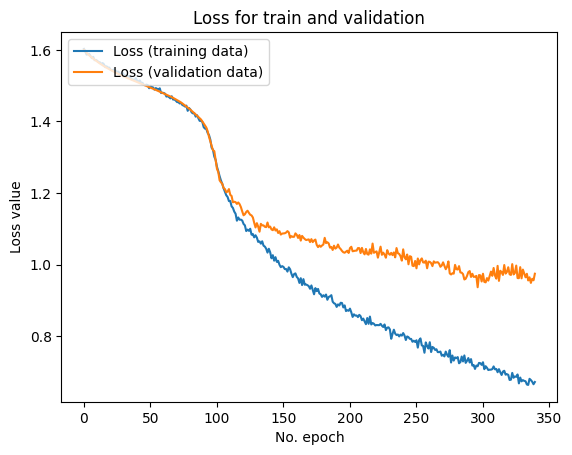

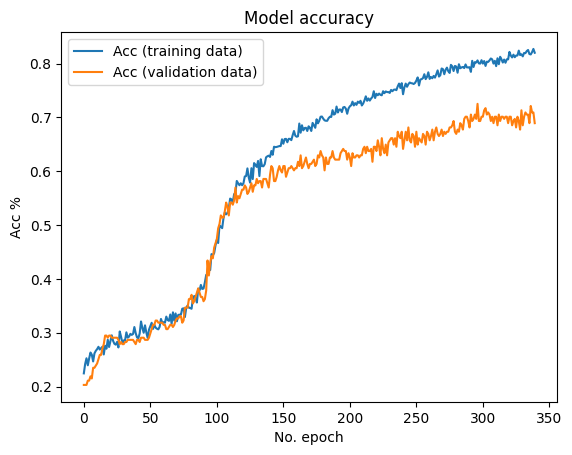

In [32]:
learning_curve(history)

8/8 - 0s - 41ms/step - categorical_accuracy: 0.7251 - loss: 0.9326
Model validation loss: 0.9325688481330872
Model validation accuracy: 0.7250996232032776
y_val shape: (251, 4)
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


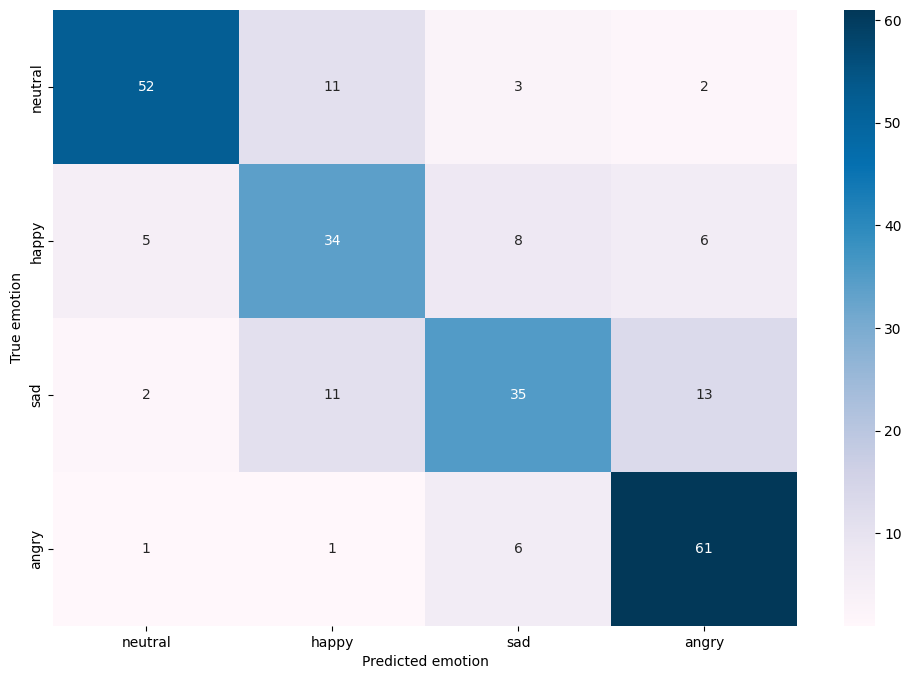

In [33]:
validation_evaluation(model, x_val, y_val)

4/4 - 0s - 47ms/step - categorical_accuracy: 0.7658 - loss: 0.7800
Model test loss: 0.7800155878067017
Model test accuracy: 0.7657657861709595
y_test shape: (111, 4)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


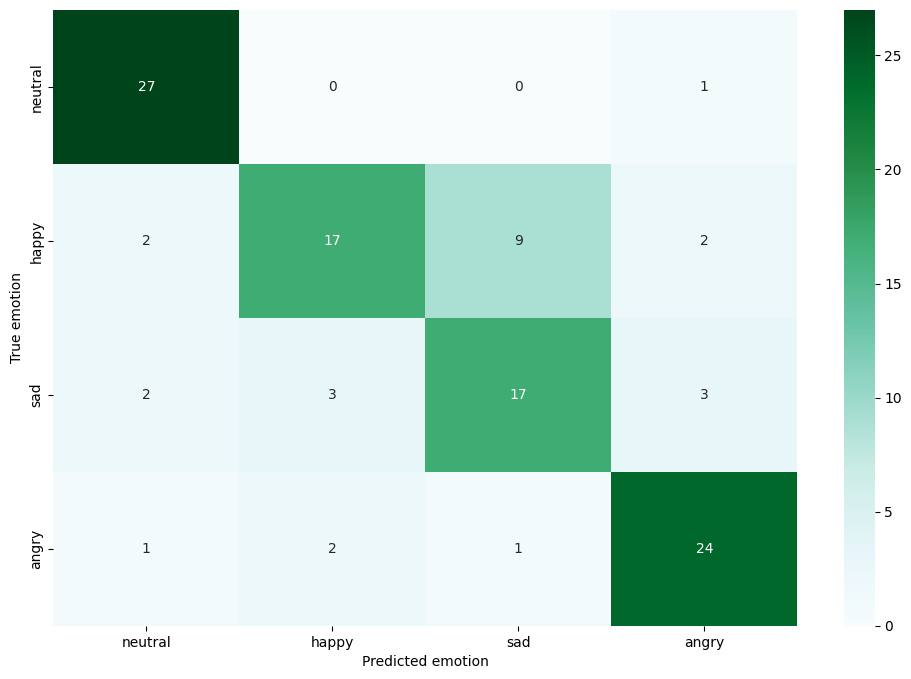

In [35]:
test_evaluation(model, x_test, y_test)

In [36]:
#train EYASE Augmented dataset 
history, model = lstm(neuron1 =16,
neuron2 = 32,
l2= 0.001,
dropout = 0.5,
batch_size = 512,
epochs = 340,
l_rate = 0.0001,
output_path = 'best_weights_EYASE_Augmented_16_32.keras')

C:\Users\H P\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 108, 16)             │          11,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 108, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,412 (68.02 KB)

 Trainable params: 17,412 (68.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 731ms/step - categorical_accuracy: 0.2608 - loss: 1.5172 - val_categorical_accuracy: 0.2550 - val_loss: 1.5065 - learning_rate: 1.0000e-04
Epoch 2/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - categorical_accuracy: 0.2563 - loss: 1.5146 - val_categorical_accuracy: 0.2590 - val_loss: 1.5051 - learning_rate: 1.0000e-04
Epoch 3/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - categorical_accuracy: 0.2389 - loss: 1.5124 - val_categorical_accuracy: 0.2550 - val_loss: 1.5038 - learning_rate: 1.0000e-04
Epoch 4/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - categorical_accuracy: 0.2688 - loss: 1.5107 - val_categorical_accuracy: 0.2629 - val_loss: 1.5024 - learning_rate: 1.0000e-04
Epoch 5/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - categorical_accuracy: 0.2618 - loss: 1.5056 - val_categorical_accuracy: 0.2629 - val_loss: 1.5011 - learning_rate: 1.0000e-04
Epoch 6/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 513ms/step - categorical_accuracy: 0.2809 - loss: 1.5048 - 

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - categorical_accuracy: 0.3201 - loss: 1.4168 - val_categorical_accuracy: 0.3426 - val_loss: 1.4117 - learning_rate: 1.0000e-04
Epoch 78/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - categorical_accuracy: 0.3374 - loss: 1.4101 - val_categorical_accuracy: 0.3426 - val_loss: 1.4085 - learning_rate: 1.0000e-04
Epoch 79/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - categorical_accuracy: 0.3291 - loss: 1.4172 - val_categorical_accuracy: 0.3586 - val_loss: 1.4047 - learning_rate: 1.0000e-04
Epoch 80/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - categorical_accuracy: 0.3144 - loss: 1.4183 - val_categorical_accuracy: 0.3705 - val_loss: 1.4003 - learning_rate: 1.0000e-04
Epoch 81/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - categorical_accuracy: 0.3452 - loss: 1.4102 - val_categorical_accuracy: 0.3865 - val_loss: 1.3950 - learning_rate: 1.0000e-04
Epoch 82/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - categorical_accuracy: 0.3437 - loss: 1.4021 - val_categoric

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - categorical_accuracy: 0.5462 - loss: 1.0816 - val_categorical_accuracy: 0.5618 - val_loss: 1.0629 - learning_rate: 1.0000e-04
Epoch 154/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - categorical_accuracy: 0.5489 - loss: 1.0874 - val_categorical_accuracy: 0.5817 - val_loss: 1.0654 - learning_rate: 1.0000e-04
Epoch 155/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - categorical_accuracy: 0.5587 - loss: 1.0823 - val_categorical_accuracy: 0.5657 - val_loss: 1.0574 - learning_rate: 1.0000e-04
Epoch 156/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 451ms/step - categorical_accuracy: 0.5587 - loss: 1.0655 - val_categorical_accuracy: 0.5737 - val_loss: 1.0597 - learning_rate: 1.0000e-04
Epoch 157/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - categorical_accuracy: 0.5580 - loss: 1.0679 - val_categorical_accuracy: 0.5697 - val_loss: 1.0612 - learning_rate: 1.0000e-04
Epoch 158/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - categorical_accuracy: 0.5471 - loss: 1.0769 - val_cate

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - categorical_accuracy: 0.6417 - loss: 0.9347 - val_categorical_accuracy: 0.6375 - val_loss: 0.9608 - learning_rate: 1.0000e-04
Epoch 230/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - categorical_accuracy: 0.6427 - loss: 0.9289 - val_categorical_accuracy: 0.6215 - val_loss: 0.9694 - learning_rate: 1.0000e-04
Epoch 231/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - categorical_accuracy: 0.6529 - loss: 0.9280 - val_categorical_accuracy: 0.6335 - val_loss: 0.9538 - learning_rate: 1.0000e-04
Epoch 232/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - categorical_accuracy: 0.6403 - loss: 0.9339 - val_categorical_accuracy: 0.6375 - val_loss: 0.9611 - learning_rate: 1.0000e-04
Epoch 233/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - categorical_accuracy: 0.6482 - loss: 0.9360 - val_categorical_accuracy: 0.6335 - val_loss: 0.9552 - learning_rate: 1.0000e-04
Epoch 234/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - categorical_accuracy: 0.6394 - loss: 0.9317 - val_cate

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - categorical_accuracy: 0.7046 - loss: 0.8186 - val_categorical_accuracy: 0.6813 - val_loss: 0.8872 - learning_rate: 1.0000e-04
Epoch 306/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - categorical_accuracy: 0.7007 - loss: 0.8357 - val_categorical_accuracy: 0.6653 - val_loss: 0.8824 - learning_rate: 1.0000e-04
Epoch 307/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - categorical_accuracy: 0.7011 - loss: 0.8176 - val_categorical_accuracy: 0.6773 - val_loss: 0.8729 - learning_rate: 1.0000e-04
Epoch 308/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - categorical_accuracy: 0.7086 - loss: 0.8235 - val_categorical_accuracy: 0.6733 - val_loss: 0.8807 - learning_rate: 1.0000e-04
Epoch 309/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - categorical_accuracy: 0.7065 - loss: 0.8123 - val_categorical_accuracy: 0.6773 - val_loss: 0.8793 - learning_rate: 1.0000e-04
Epoch 310/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - categorical_accuracy: 0.7127 - loss: 0.8129 - val_cate

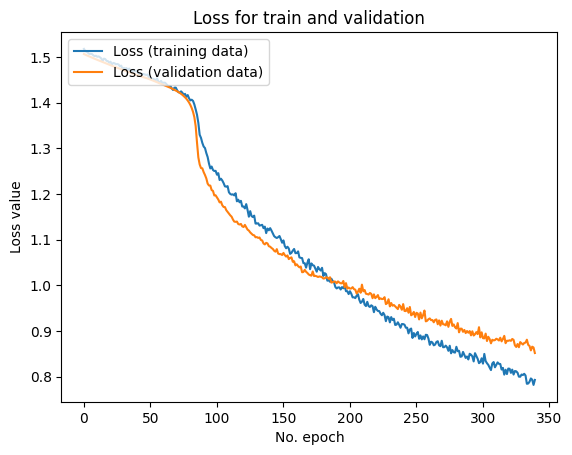

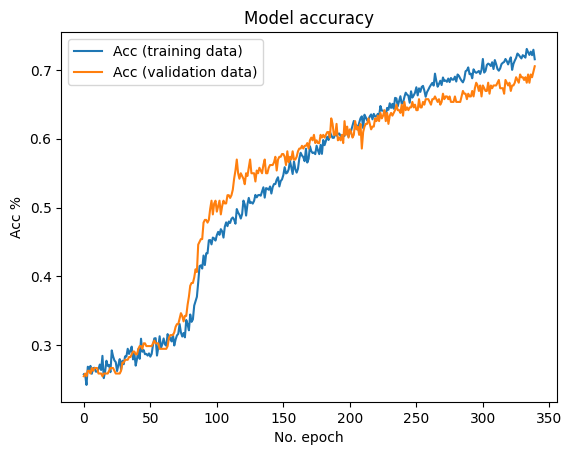

In [37]:
learning_curve(history)

8/8 - 0s - 39ms/step - categorical_accuracy: 0.7052 - loss: 0.8521
Model validation loss: 0.8520631790161133
Model validation accuracy: 0.7051792740821838
y_val shape: (251, 4)
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


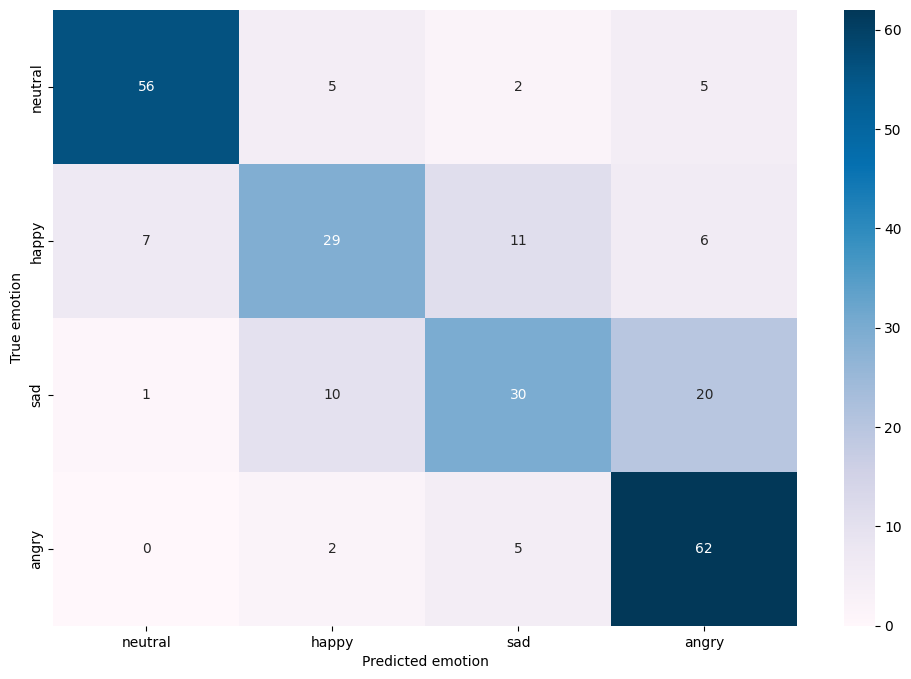

In [38]:
validation_evaluation(model, x_val, y_val)

4/4 - 0s - 42ms/step - categorical_accuracy: 0.6577 - loss: 0.8589
Model test loss: 0.8588953018188477
Model test accuracy: 0.6576576828956604
y_test shape: (111, 4)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


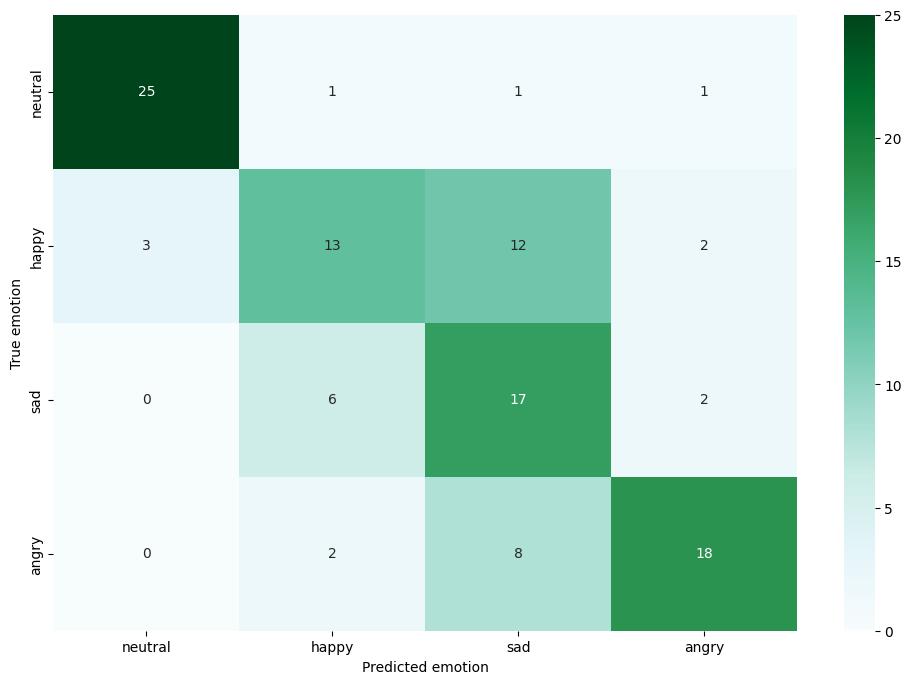

In [39]:
test_evaluation(model, x_test, y_test)

In [40]:
#train EYASE Augmented dataset 
history, model = lstm(neuron1 =32,
neuron2 = 32,
l2= 0.01,
dropout = 0.5,
batch_size = 512,
epochs = 340,
l_rate = 0.0001,
output_path = 'best_weights_EYASE_Augmented_32_more_regularization.keras')

C:\Users\H P\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 108, 32)             │          24,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 108, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,516 (127.02 KB)

 Trainable params: 32,516 (127.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 850ms/step - categorical_accuracy: 0.2608 - loss: 3.2900 - val_categorical_accuracy: 0.2629 - val_loss: 3.2769 - learning_rate: 1.0000e-04
Epoch 2/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 578ms/step - categorical_accuracy: 0.2563 - loss: 3.2765 - val_categorical_accuracy: 0.2709 - val_loss: 3.2588 - learning_rate: 1.0000e-04
Epoch 3/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 577ms/step - categorical_accuracy: 0.2622 - loss: 3.2567 - val_categorical_accuracy: 0.2789 - val_loss: 3.2411 - learning_rate: 1.0000e-04
Epoch 4/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 591ms/step - categorical_accuracy: 0.2662 - loss: 3.2457 - val_categorical_accuracy: 0.2829 - val_loss: 3.2234 - learning_rate: 1.0000e-04
Epoch 5/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - categorical_accuracy: 0.2687 - loss: 3.2233 - val_categorical_accuracy: 0.2789 - val_loss: 3.2060 - learning_rate: 1.0000e-04
Epoch 6/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 590ms/step - categorical_accuracy: 0.2710 - loss: 3.2067 - 

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - categorical_accuracy: 0.3490 - loss: 2.2612 - val_categorical_accuracy: 0.4183 - val_loss: 2.2256 - learning_rate: 1.0000e-04
Epoch 78/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - categorical_accuracy: 0.3365 - loss: 2.2500 - val_categorical_accuracy: 0.4382 - val_loss: 2.1997 - learning_rate: 1.0000e-04
Epoch 79/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - categorical_accuracy: 0.3658 - loss: 2.2168 - val_categorical_accuracy: 0.4343 - val_loss: 2.1630 - learning_rate: 1.0000e-04
Epoch 80/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - categorical_accuracy: 0.3888 - loss: 2.1997 - val_categorical_accuracy: 0.4741 - val_loss: 2.1241 - learning_rate: 1.0000e-04
Epoch 81/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - categorical_accuracy: 0.4213 - loss: 2.1550 - val_categorical_accuracy: 0.4861 - val_loss: 2.0943 - learning_rate: 1.0000e-04
Epoch 82/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - categorical_accuracy: 0.4194 - loss: 2.1373 - val_categoric

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - categorical_accuracy: 0.5962 - loss: 1.4910 - val_categorical_accuracy: 0.5777 - val_loss: 1.5230 - learning_rate: 1.0000e-04
Epoch 154/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - categorical_accuracy: 0.5777 - loss: 1.5196 - val_categorical_accuracy: 0.5737 - val_loss: 1.5160 - learning_rate: 1.0000e-04
Epoch 155/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - categorical_accuracy: 0.5820 - loss: 1.5170 - val_categorical_accuracy: 0.5737 - val_loss: 1.5225 - learning_rate: 1.0000e-04
Epoch 156/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - categorical_accuracy: 0.5867 - loss: 1.5003 - val_categorical_accuracy: 0.6016 - val_loss: 1.4987 - learning_rate: 1.0000e-04
Epoch 157/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - categorical_accuracy: 0.5968 - loss: 1.4925 - val_categorical_accuracy: 0.5777 - val_loss: 1.5019 - learning_rate: 1.0000e-04
Epoch 158/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - categorical_accuracy: 0.5953 - loss: 1.4851 - val_cate

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - categorical_accuracy: 0.7084 - loss: 1.1051 - val_categorical_accuracy: 0.6813 - val_loss: 1.1577 - learning_rate: 1.0000e-04
Epoch 230/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - categorical_accuracy: 0.6925 - loss: 1.1148 - val_categorical_accuracy: 0.6813 - val_loss: 1.1533 - learning_rate: 1.0000e-04
Epoch 231/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - categorical_accuracy: 0.6983 - loss: 1.1294 - val_categorical_accuracy: 0.6932 - val_loss: 1.1532 - learning_rate: 1.0000e-04
Epoch 232/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - categorical_accuracy: 0.6867 - loss: 1.1066 - val_categorical_accuracy: 0.6892 - val_loss: 1.1409 - learning_rate: 1.0000e-04
Epoch 233/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - categorical_accuracy: 0.6895 - loss: 1.1060 - val_categorical_accuracy: 0.6773 - val_loss: 1.1634 - learning_rate: 1.0000e-04
Epoch 234/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - categorical_accuracy: 0.6918 - loss: 1.1165 - val_cate

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - categorical_accuracy: 0.7711 - loss: 0.8893 - val_categorical_accuracy: 0.7211 - val_loss: 1.0336 - learning_rate: 1.0000e-04
Epoch 306/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - categorical_accuracy: 0.7641 - loss: 0.8926 - val_categorical_accuracy: 0.7211 - val_loss: 1.0179 - learning_rate: 1.0000e-04
Epoch 307/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - categorical_accuracy: 0.7661 - loss: 0.8897 - val_categorical_accuracy: 0.7211 - val_loss: 1.0530 - learning_rate: 1.0000e-04
Epoch 308/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - categorical_accuracy: 0.7697 - loss: 0.8883 - val_categorical_accuracy: 0.7171 - val_loss: 1.0173 - learning_rate: 1.0000e-04
Epoch 309/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 489ms/step - categorical_accuracy: 0.7717 - loss: 0.8835 - val_categorical_accuracy: 0.7211 - val_loss: 1.0327 - learning_rate: 1.0000e-04
Epoch 310/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - categorical_accuracy: 0.7793 - loss: 0.8825 - val_cate

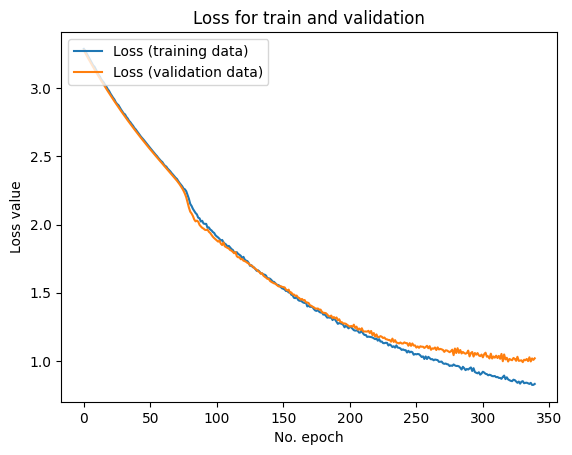

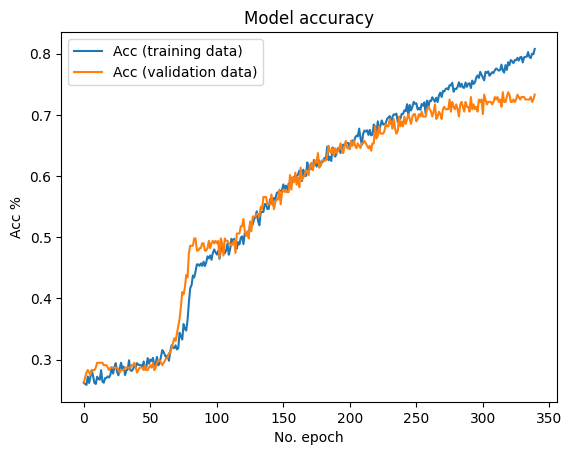

In [41]:
learning_curve(history)

8/8 - 0s - 43ms/step - categorical_accuracy: 0.7371 - loss: 0.9959
Model validation loss: 0.995861291885376
Model validation accuracy: 0.737051784992218
y_val shape: (251, 4)
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


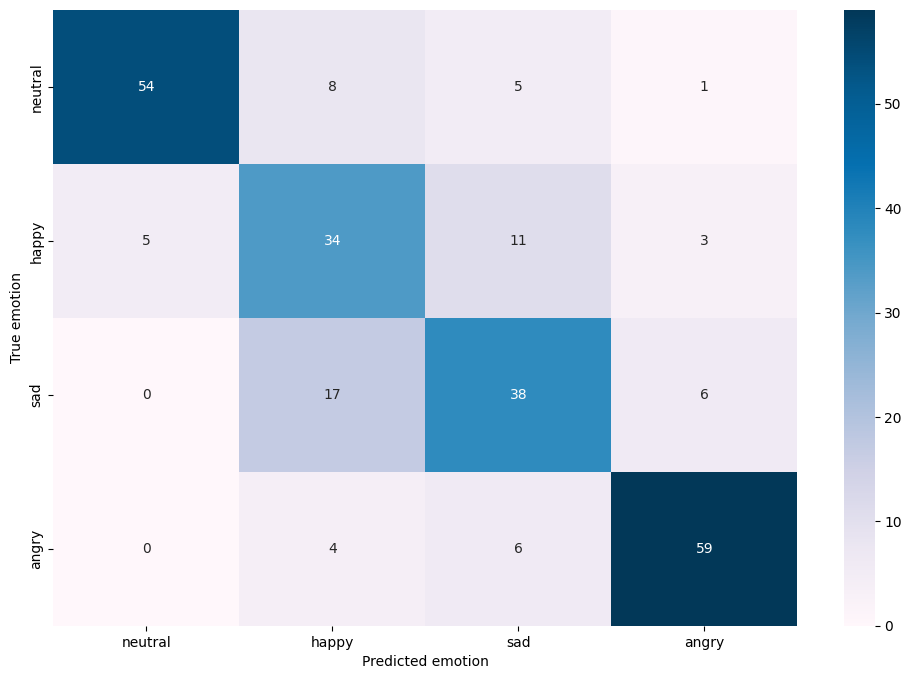

In [42]:
validation_evaluation(model, x_val, y_val)

4/4 - 0s - 44ms/step - categorical_accuracy: 0.6937 - loss: 1.0728
Model test loss: 1.0727957487106323
Model test accuracy: 0.6936936974525452
y_test shape: (111, 4)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


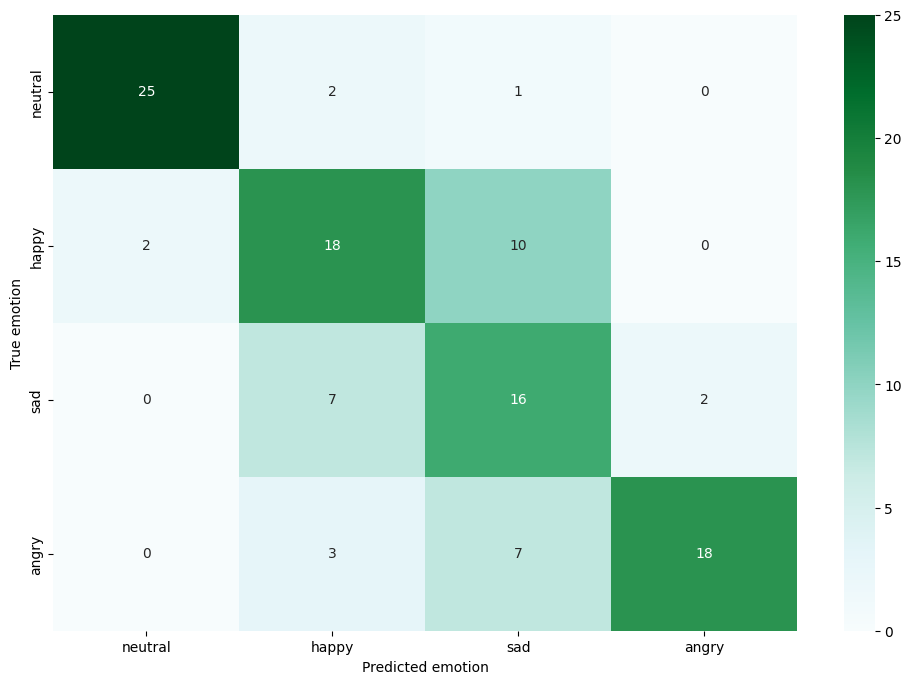

In [43]:
test_evaluation(model, x_test, y_test)

In [44]:
#train EYASE Augmented dataset 
history, model = lstm(neuron1 =16,
neuron2 = 32,
l2= 0.01,
dropout = 0.5,
batch_size = 512,
epochs = 340,
l_rate = 0.0001,
output_path = 'best_weights_EYASE_Augmented_16_32_more_regularization.keras')

C:\Users\H P\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 108, 16)             │          11,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 108, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,412 (68.02 KB)

 Trainable params: 17,412 (68.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 945ms/step - categorical_accuracy: 0.2622 - loss: 2.5998 - val_categorical_accuracy: 0.2231 - val_loss: 2.5841 - learning_rate: 1.0000e-04
Epoch 2/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - categorical_accuracy: 0.2606 - loss: 2.5883 - val_categorical_accuracy: 0.2231 - val_loss: 2.5730 - learning_rate: 1.0000e-04
Epoch 3/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - categorical_accuracy: 0.2668 - loss: 2.5795 - val_categorical_accuracy: 0.2311 - val_loss: 2.5621 - learning_rate: 1.0000e-04
Epoch 4/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - categorical_accuracy: 0.2491 - loss: 2.5696 - val_categorical_accuracy: 0.2311 - val_loss: 2.5516 - learning_rate: 1.0000e-04
Epoch 5/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step - categorical_accuracy: 0.2662 - loss: 2.5556 - val_categorical_accuracy: 0.2351 - val_loss: 2.5412 - learning_rate: 1.0000e-04
Epoch 6/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - categorical_accuracy: 0.2578 - loss: 2.5490 - 

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - categorical_accuracy: 0.3110 - loss: 2.0035 - val_categorical_accuracy: 0.2829 - val_loss: 1.9904 - learning_rate: 1.0000e-04
Epoch 78/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 380ms/step - categorical_accuracy: 0.3046 - loss: 2.0000 - val_categorical_accuracy: 0.2829 - val_loss: 1.9841 - learning_rate: 1.0000e-04
Epoch 79/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step - categorical_accuracy: 0.2896 - loss: 1.9952 - val_categorical_accuracy: 0.2908 - val_loss: 1.9778 - learning_rate: 1.0000e-04
Epoch 80/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 387ms/step - categorical_accuracy: 0.3024 - loss: 1.9845 - val_categorical_accuracy: 0.2948 - val_loss: 1.9714 - learning_rate: 1.0000e-04
Epoch 81/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - categorical_accuracy: 0.3043 - loss: 1.9801 - val_categorical_accuracy: 0.2908 - val_loss: 1.9649 - learning_rate: 1.0000e-04
Epoch 82/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step - categorical_accuracy: 0.3069 - loss: 1.9722 - val_categoric

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - categorical_accuracy: 0.5198 - loss: 1.4570 - val_categorical_accuracy: 0.5418 - val_loss: 1.4403 - learning_rate: 1.0000e-04
Epoch 154/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - categorical_accuracy: 0.5054 - loss: 1.4508 - val_categorical_accuracy: 0.5458 - val_loss: 1.4394 - learning_rate: 1.0000e-04
Epoch 155/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - categorical_accuracy: 0.5138 - loss: 1.4493 - val_categorical_accuracy: 0.5378 - val_loss: 1.4386 - learning_rate: 1.0000e-04
Epoch 156/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - categorical_accuracy: 0.5300 - loss: 1.4401 - val_categorical_accuracy: 0.5378 - val_loss: 1.4359 - learning_rate: 1.0000e-04
Epoch 157/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - categorical_accuracy: 0.5314 - loss: 1.4363 - val_categorical_accuracy: 0.5299 - val_loss: 1.4301 - learning_rate: 1.0000e-04
Epoch 158/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - categorical_accuracy: 0.5369 - loss: 1.4199 - val_cate

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - categorical_accuracy: 0.6303 - loss: 1.1465 - val_categorical_accuracy: 0.6454 - val_loss: 1.1434 - learning_rate: 1.0000e-04
Epoch 230/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - categorical_accuracy: 0.6277 - loss: 1.1466 - val_categorical_accuracy: 0.6135 - val_loss: 1.1643 - learning_rate: 1.0000e-04
Epoch 231/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - categorical_accuracy: 0.6239 - loss: 1.1281 - val_categorical_accuracy: 0.6335 - val_loss: 1.1427 - learning_rate: 1.0000e-04
Epoch 232/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - categorical_accuracy: 0.6257 - loss: 1.1287 - val_categorical_accuracy: 0.6255 - val_loss: 1.1530 - learning_rate: 1.0000e-04
Epoch 233/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - categorical_accuracy: 0.6510 - loss: 1.1238 - val_categorical_accuracy: 0.6653 - val_loss: 1.1348 - learning_rate: 1.0000e-04
Epoch 234/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - categorical_accuracy: 0.6315 - loss: 1.1392 - val_cate

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - categorical_accuracy: 0.7100 - loss: 0.9255 - val_categorical_accuracy: 0.6693 - val_loss: 1.0101 - learning_rate: 1.0000e-04
Epoch 306/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - categorical_accuracy: 0.7017 - loss: 0.9317 - val_categorical_accuracy: 0.6494 - val_loss: 1.0289 - learning_rate: 1.0000e-04
Epoch 307/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - categorical_accuracy: 0.6980 - loss: 0.9434 - val_categorical_accuracy: 0.6773 - val_loss: 1.0107 - learning_rate: 1.0000e-04
Epoch 308/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - categorical_accuracy: 0.6834 - loss: 0.9534 - val_categorical_accuracy: 0.6375 - val_loss: 1.0371 - learning_rate: 1.0000e-04
Epoch 309/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - categorical_accuracy: 0.6886 - loss: 0.9530 - val_categorical_accuracy: 0.6614 - val_loss: 1.0209 - learning_rate: 1.0000e-04
Epoch 310/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - categorical_accuracy: 0.6911 - loss: 0.9520 - val_cate

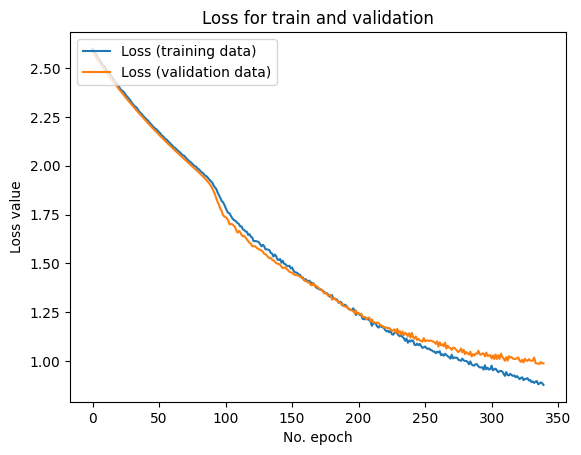

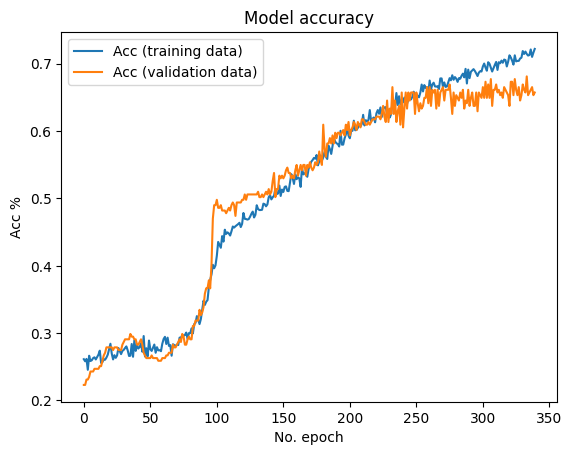

In [45]:
learning_curve(history)

8/8 - 0s - 23ms/step - categorical_accuracy: 0.6813 - loss: 0.9901
Model validation loss: 0.9901270866394043
Model validation accuracy: 0.6812748908996582
y_val shape: (251, 4)
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


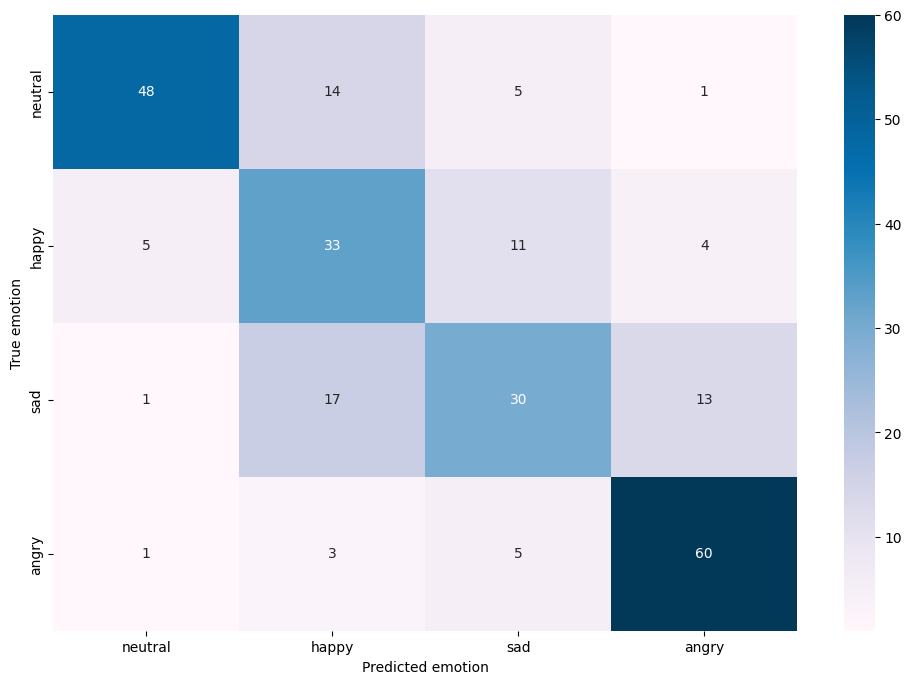

In [46]:
validation_evaluation(model, x_val, y_val)

4/4 - 0s - 27ms/step - categorical_accuracy: 0.5946 - loss: 1.0648
Model test loss: 1.0647592544555664
Model test accuracy: 0.5945945978164673
y_test shape: (111, 4)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


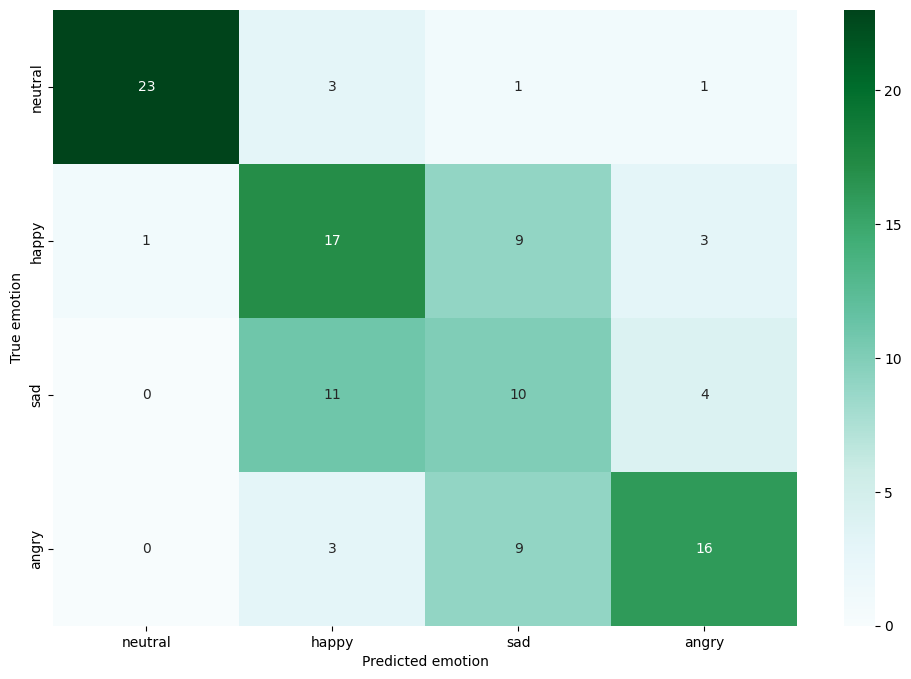

In [47]:
test_evaluation(model, x_test, y_test)

### EYASE Agumented 2 features training

In [48]:
# Test that X and y are reay for training on EYASE Augmented Dataset
X = concatenate_features( mfcc_lstm, mel_lstm)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2895, 108, 141)
y shape: (2895, 1)


In [49]:
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, y, test_size = 0.125, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 42)

#'One-hot' vectors for Y: emotion classification
y_train = tf.keras.utils.to_categorical(y_train, 4)
y_val = tf.keras.utils.to_categorical(y_val, 4)
y_test = tf.keras.utils.to_categorical(y_test, 4)

# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(2533, 108, 141)
(251, 108, 141)
(111, 108, 141)
(2533, 4)
(251, 4)
(111, 4)


In [50]:
#train EYASE Augmented dataset 
history, model = lstm(neuron1 =32,
neuron2 = 32,
l2= 0.001,
dropout = 0.5,
batch_size = 512,
epochs = 340,
l_rate = 0.0001,
output_path = 'best_weights_EYASE_Augmented_32_2features.keras')

C:\Users\H P\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 108, 32)             │          22,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 108, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,724 (120.02 KB)

 Trainable params: 30,724 (120.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 431ms/step - categorical_accuracy: 0.2536 - loss: 1.5762 - val_categorical_accuracy: 0.2629 - val_loss: 1.5706 - learning_rate: 1.0000e-04
Epoch 2/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - categorical_accuracy: 0.2530 - loss: 1.5730 - val_categorical_accuracy: 0.2709 - val_loss: 1.5675 - learning_rate: 1.0000e-04
Epoch 3/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - categorical_accuracy: 0.2641 - loss: 1.5712 - val_categorical_accuracy: 0.2829 - val_loss: 1.5646 - learning_rate: 1.0000e-04
Epoch 4/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - categorical_accuracy: 0.2713 - loss: 1.5675 - val_categorical_accuracy: 0.2869 - val_loss: 1.5620 - learning_rate: 1.0000e-04
Epoch 5/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - categorical_accuracy: 0.2535 - loss: 1.5693 - val_categorical_accuracy: 0.3028 - val_loss: 1.5595 - learning_rate: 1.0000e-04
Epoch 6/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - categorical_accuracy: 0.2762 - loss: 1.5635 - v

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - categorical_accuracy: 0.4387 - loss: 1.3331 - val_categorical_accuracy: 0.4940 - val_loss: 1.2722 - learning_rate: 1.0000e-04
Epoch 78/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - categorical_accuracy: 0.4567 - loss: 1.3165 - val_categorical_accuracy: 0.4900 - val_loss: 1.2700 - learning_rate: 1.0000e-04
Epoch 79/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - categorical_accuracy: 0.4599 - loss: 1.2966 - val_categorical_accuracy: 0.5100 - val_loss: 1.2547 - learning_rate: 1.0000e-04
Epoch 80/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - categorical_accuracy: 0.4541 - loss: 1.2996 - val_categorical_accuracy: 0.5060 - val_loss: 1.2500 - learning_rate: 1.0000e-04
Epoch 81/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - categorical_accuracy: 0.4816 - loss: 1.2846 - val_categorical_accuracy: 0.4980 - val_loss: 1.2576 - learning_rate: 1.0000e-04
Epoch 82/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - categorical_accuracy: 0.4715 - loss: 1.2853 - val_categoric

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - categorical_accuracy: 0.6183 - loss: 1.0499 - val_categorical_accuracy: 0.6215 - val_loss: 1.0599 - learning_rate: 1.0000e-04
Epoch 154/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - categorical_accuracy: 0.6190 - loss: 1.0332 - val_categorical_accuracy: 0.6135 - val_loss: 1.0646 - learning_rate: 1.0000e-04
Epoch 155/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - categorical_accuracy: 0.6097 - loss: 1.0510 - val_categorical_accuracy: 0.6096 - val_loss: 1.0606 - learning_rate: 1.0000e-04
Epoch 156/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - categorical_accuracy: 0.6145 - loss: 1.0423 - val_categorical_accuracy: 0.6295 - val_loss: 1.0544 - learning_rate: 1.0000e-04
Epoch 157/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - categorical_accuracy: 0.6253 - loss: 1.0403 - val_categorical_accuracy: 0.6016 - val_loss: 1.0631 - learning_rate: 1.0000e-04
Epoch 158/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - categorical_accuracy: 0.6141 - loss: 1.0484 - val_cate

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - categorical_accuracy: 0.6854 - loss: 0.8938 - val_categorical_accuracy: 0.6733 - val_loss: 0.9425 - learning_rate: 1.0000e-04
Epoch 230/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - categorical_accuracy: 0.6774 - loss: 0.9115 - val_categorical_accuracy: 0.6733 - val_loss: 0.9626 - learning_rate: 1.0000e-04
Epoch 231/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step - categorical_accuracy: 0.6747 - loss: 0.9023 - val_categorical_accuracy: 0.6733 - val_loss: 0.9431 - learning_rate: 1.0000e-04
Epoch 232/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - categorical_accuracy: 0.6764 - loss: 0.9020 - val_categorical_accuracy: 0.6534 - val_loss: 0.9739 - learning_rate: 1.0000e-04
Epoch 233/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - categorical_accuracy: 0.6821 - loss: 0.9094 - val_categorical_accuracy: 0.6653 - val_loss: 0.9581 - learning_rate: 1.0000e-04
Epoch 234/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - categorical_accuracy: 0.6844 - loss: 0.8743 - val_cate

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - categorical_accuracy: 0.7363 - loss: 0.8236 - val_categorical_accuracy: 0.7131 - val_loss: 0.8910 - learning_rate: 1.0000e-04
Epoch 306/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step - categorical_accuracy: 0.7375 - loss: 0.7966 - val_categorical_accuracy: 0.7012 - val_loss: 0.8950 - learning_rate: 1.0000e-04
Epoch 307/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - categorical_accuracy: 0.7342 - loss: 0.8044 - val_categorical_accuracy: 0.7131 - val_loss: 0.8816 - learning_rate: 1.0000e-04
Epoch 308/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - categorical_accuracy: 0.7320 - loss: 0.8198 - val_categorical_accuracy: 0.7131 - val_loss: 0.8873 - learning_rate: 1.0000e-04
Epoch 309/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - categorical_accuracy: 0.7351 - loss: 0.8118 - val_categorical_accuracy: 0.6892 - val_loss: 0.8757 - learning_rate: 1.0000e-04
Epoch 310/340
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - categorical_accuracy: 0.7452 - loss: 0.7807 - val_cate

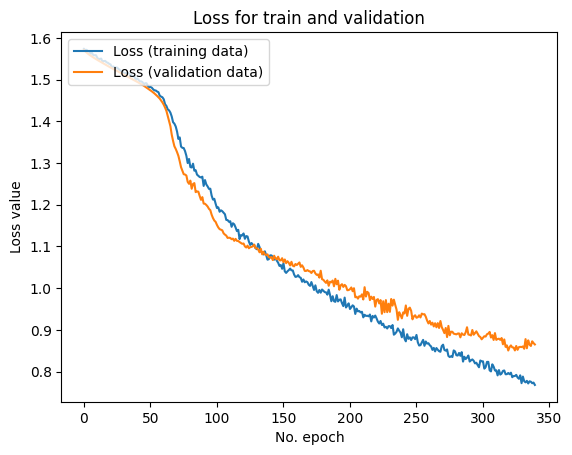

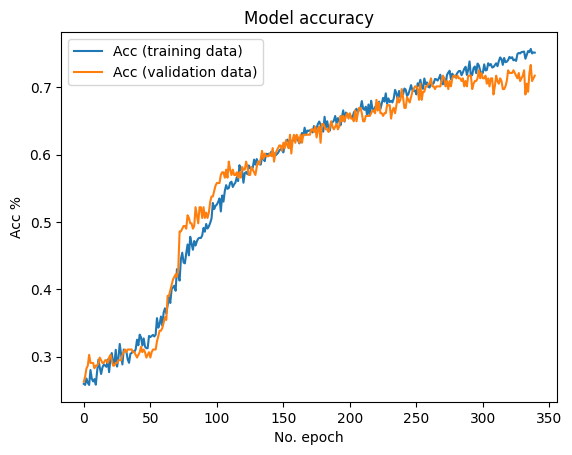

In [51]:
learning_curve(history)

8/8 - 0s - 29ms/step - categorical_accuracy: 0.7331 - loss: 0.8582
Model validation loss: 0.8582465052604675
Model validation accuracy: 0.7330677509307861
y_val shape: (251, 4)
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step


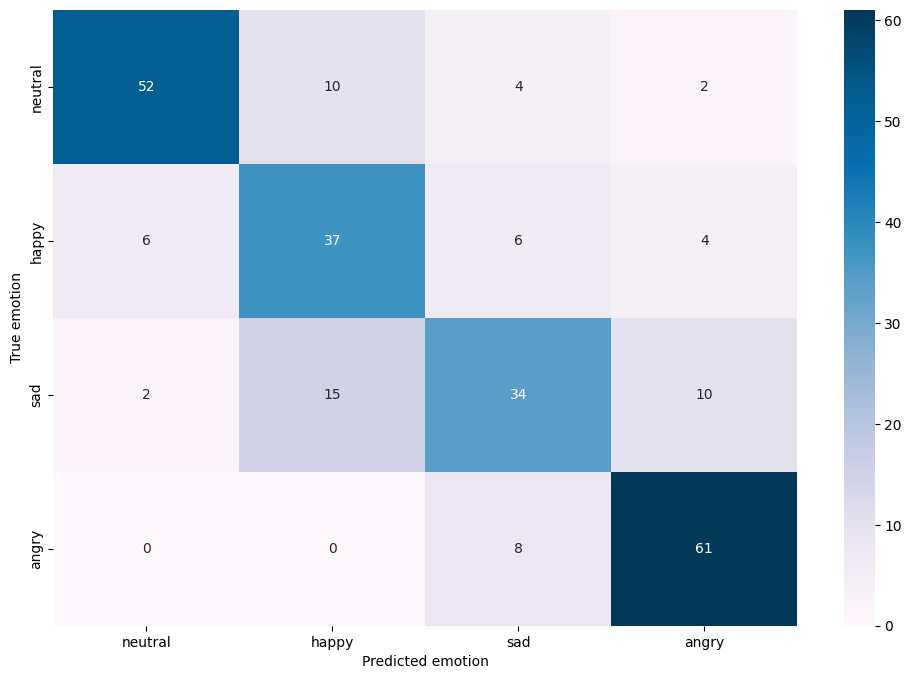

In [52]:
validation_evaluation(model, x_val, y_val)

4/4 - 0s - 27ms/step - categorical_accuracy: 0.6577 - loss: 0.9792
Model test loss: 0.9791690707206726
Model test accuracy: 0.6576576828956604
y_test shape: (111, 4)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


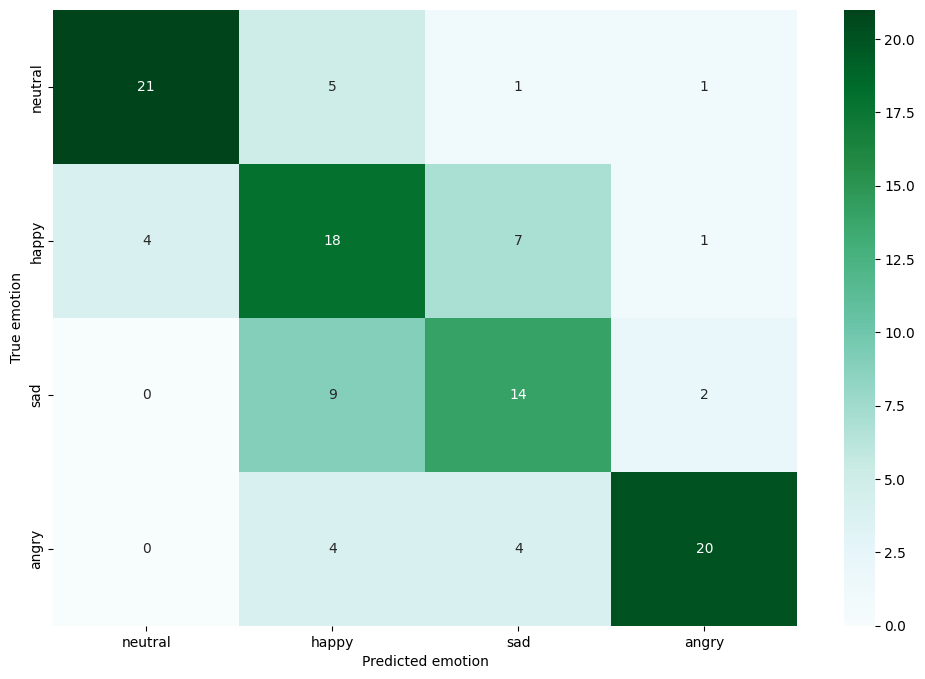

In [53]:
test_evaluation(model, x_test, y_test)

### EAED & EYASE Dataset

In [4]:
zcr_array, c_stft_array, mfcc_array, rms_array, mel_array, y = feature_extraction_merged("E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED")

Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\FEM__EYASE_ang_100000.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\FEM__EYASE_ang_100001.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\FEM__EYASE_ang_100002.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\FEM__EYASE_ang_100003.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\FEM__EYASE_ang_100004.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\FEM__EYASE_ang_100005.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\FEM__EYASE_ang_100006.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanill

Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\MAL__EYASE_ang_100240.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\MAL__EYASE_ang_100241.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\MAL__EYASE_ang_100242.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\MAL__EYASE_ang_100243.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\MAL__EYASE_ang_100244.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\MAL__EYASE_ang_100245.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED\MAL__EYASE_ang_100246.wav because emotion label not found.
Skipping file E:/uni/4th year/grad project/final_output_vanill

In [35]:
# Print the shapes of the arrays
print("Shapes of features after padding:")
print("Zero Crossing Rate (zcr):", zcr_array.shape)
print("Chroma STFT (c_stft):", c_stft_array.shape)
print("MFCC (mfcc):", mfcc_array.shape)
print("RMS (rms):", rms_array.shape)
print("Mel Spectrogram (mel):", mel_array.shape)
print("y:", y.shape)

Shapes of features after padding:
Zero Crossing Rate (zcr): (2962, 1, 501)
Chroma STFT (c_stft): (2962, 12, 501)
MFCC (mfcc): (2962, 13, 501)
RMS (rms): (2962, 1, 501)
Mel Spectrogram (mel): (2962, 128, 501)
y: (2962, 1)


In [36]:
# check preprocessing for EYASE Augmented dataset
zcr_lstm, c_stft_lstm,  mfcc_lstm, rms_lstm, mel_lstm = preprocessing_merged(zcr_array, c_stft_array, mfcc_array, rms_array, mel_array)
# Verify shapes
print("Reshaped shapes for LSTM input:")
print("Zero Crossing Rate (zcr_lstm):", zcr_lstm.shape)
print("Chroma STFT (c_stft_lstm):", c_stft_lstm.shape)
print("MFCC (mfcc_lstm):", mfcc_lstm.shape)
print("RMS (rms_lstm):", rms_lstm.shape)
print("Mel Spectrogram (mel_lstm):", mel_lstm.shape)

Reshaped shapes for LSTM input:
Zero Crossing Rate (zcr_lstm): (2962, 501, 1)
Chroma STFT (c_stft_lstm): (2962, 501, 12)
MFCC (mfcc_lstm): (2962, 501, 13)
RMS (rms_lstm): (2962, 501, 1)
Mel Spectrogram (mel_lstm): (2962, 501, 128)


In [39]:
# Test that X and y are reay for training on EYASE Dataset
X = concatenate_features( zcr_lstm, c_stft_lstm,  mfcc_lstm, rms_lstm, mel_lstm )

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2962, 501, 155)
y shape: (2962, 1)


In [40]:
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, y, test_size = 0.125, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 42)

#'One-hot' vectors for Y: emotion classification
y_train = tf.keras.utils.to_categorical(y_train, 4)
y_val = tf.keras.utils.to_categorical(y_val, 4)
y_test = tf.keras.utils.to_categorical(y_test, 4)

# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(2591, 501, 155)
(258, 501, 155)
(113, 501, 155)
(2591, 4)
(258, 4)
(113, 4)


In [ ]:
#train EYASE - EAED dataset 
history, model = lstm(neuron1 =32,
neuron2 = 32,
l2= 0.01,
dropout = 0.5,
batch_size = 512,
epochs = 340,
l_rate = 0.0001,
output_path = 'best_weights_EYASE_EAED_32_more_regularization.keras')

C:\Users\H P\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 501, 32)             │          24,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 501, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,516 (127.02 KB)

 Trainable params: 32,516 (127.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/340
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - categorical_accuracy: 0.2812 - loss: 3.2932 - val_categorical_accuracy: 0.2946 - val_loss: 3.2752 - learning_rate: 1.0000e-04
Epoch 2/340
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - categorical_accuracy: 0.2952 - loss: 3.2695 - val_categorical_accuracy: 0.2946 - val_loss: 3.2524 - learning_rate: 1.0000e-04
Epoch 3/340
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - categorical_accuracy: 0.3073 - loss: 3.2481 - val_categorical_accuracy: 0.2946 - val_loss: 3.2298 - learning_rate: 1.0000e-04
Epoch 4/340
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - categorical_accuracy: 0.3223 - loss: 3.2250 - val_categorical_accuracy: 0.2946 - val_loss: 3.2074 - learning_rate: 1.0000e-04
Epoch 5/340
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - categorical_accuracy: 0.2977 - loss: 3.2032 - val_categorical_accuracy: 0.2946 - val_loss: 3.1853 - learning_rate: 1.0000e-04
Epoch 6/340
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - categorical_accuracy: 0.3188 - loss: 3.1807 - val_categoric